<a href="https://colab.research.google.com/github/Thush099/CM2604-Churn-Classifier/blob/main/CM2604_Telco_Churn_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn — Notebook
Author: Thushanth Mahendran
Course: CM2604 Machine Learning


####Load libraries and set plotting style.

In [5]:
# 1. IMPORTS & SETTINGS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io, os
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc
)
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={"figure.figsize": (8,5)})

print("Libraries loaded. TensorFlow version:", tf.__version__)

Libraries loaded. TensorFlow version: 2.19.0


####Upload Data set

In [22]:
# 2. LOAD CSV FROM COLAB FILE DIRECTORY

import pandas as pd

csv_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(csv_path)

print("Dataset loaded from:", csv_path)
print("Shape (rows, columns):", df.shape)

print("\nFirst three rows:")
display(df.head(3))

print("\nColumn dtypes summary:")
print(df.dtypes.value_counts())

Dataset loaded from: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape (rows, columns): (7043, 21)

First three rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes



Column dtypes summary:
object     18
int64       2
float64     1
Name: count, dtype: int64


### Inspect dataset structure
Check columns, datatypes and missing values so we know what cleaning is needed.

In [7]:
# 3 - inspect columns/dtypes/missing
print("Shape (rows, cols):", df.shape)
print("\nColumns list:")
print(df.columns.tolist())

print("\nDtypes summary:")
print(df.dtypes)

print("\nMissing values (sorted):")
print(df.isna().sum().sort_values(ascending=False).head(20))

Shape (rows, cols): (7043, 21)

Columns list:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Dtypes summary:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing va

### Quick sanity checks
Look for duplicates and unusual values in ID or TotalCharges.

In [8]:
# 4 - sanity checks
# If customerID exists, check duplicates
if 'customerID' in df.columns:
    print("customerID duplicates:", df['customerID'].duplicated().sum())

# Check a few samples from TotalCharges to see formatting
if 'TotalCharges' in df.columns:
    print("\nTotalCharges sample values:")
    print(df['TotalCharges'].sample(8).values)

customerID duplicates: 0

TotalCharges sample values:
['5919.35' '89.75' '1364.75' '7159.05' '4126.35' '1166.7' '4707.85'
 '4454.25']


### Cleaning: convert TotalCharges to numeric and remove identifier
Convert TotalCharges to numeric (coerce invalid → NaN) and drop very few NaN rows.
Also drop customerID (identifier).

In [9]:
# 5 - clean TotalCharges and drop ID
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print("TotalCharges NaNs after coercion:", df['TotalCharges'].isna().sum())

# If only a tiny fraction missing, drop them and report
if 'TotalCharges' in df.columns:
    n_missing = df['TotalCharges'].isna().sum()
    if n_missing > 0 and n_missing / len(df) < 0.01:
        df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
        print("Dropped rows with missing TotalCharges. New shape:", df.shape)
    elif n_missing > 0:
        print("Warning: several TotalCharges missing; consider imputation instead of dropping.")

# Drop ID column if present
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
    print("Dropped customerID column. Shape now:", df.shape)


TotalCharges NaNs after coercion: 11
Dropped rows with missing TotalCharges. New shape: (7032, 21)
Dropped customerID column. Shape now: (7032, 20)


### Encode target and identify feature types
Encode Churn to 0/1 and show which columns are numeric and which are categorical.

In [10]:
# 6 - target encoding and feature lists
if 'Churn' not in df.columns:
    raise ValueError("No 'Churn' column found — check dataset.")
df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})

# Detect numeric and categorical
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if 'Churn' in numeric_cols:
    numeric_cols.remove('Churn')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns (count):", len(numeric_cols))
print(numeric_cols)
print("\nCategorical columns (count):", len(categorical_cols))
print(categorical_cols)
print("\nChurn distribution (proportion):")
print(df['Churn'].value_counts(normalize=True).round(3))

Numeric columns (count): 4
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical columns (count): 15
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Churn distribution (proportion):
Churn
0    0.734
1    0.266
Name: proportion, dtype: float64


### EDA: class balance and some feature relationships
Plot churn counts and a couple of numeric feature comparisons.

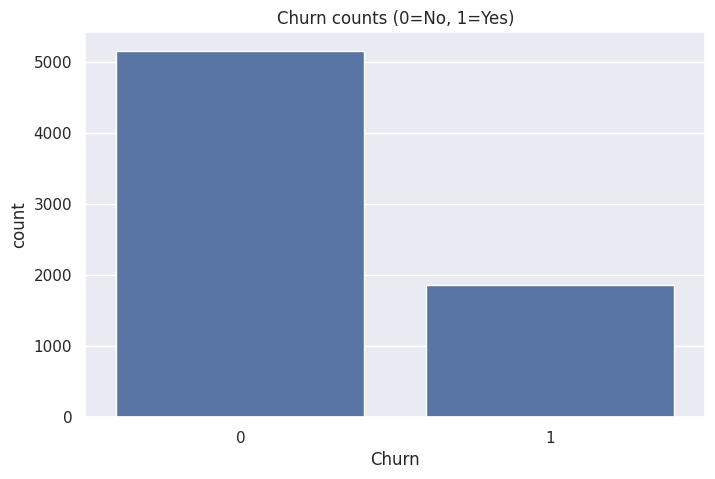

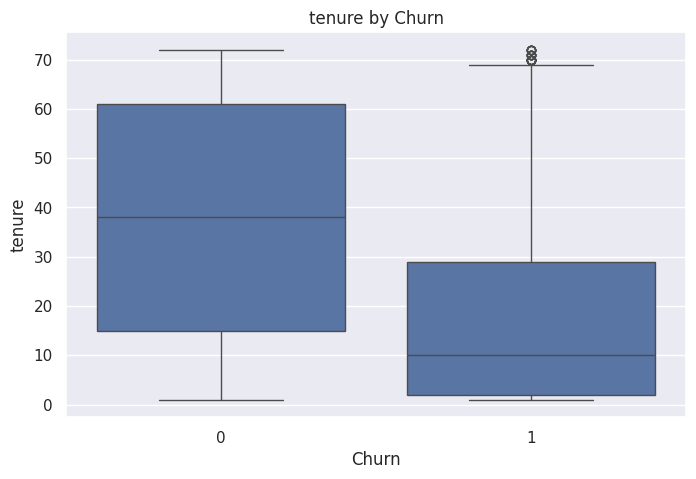

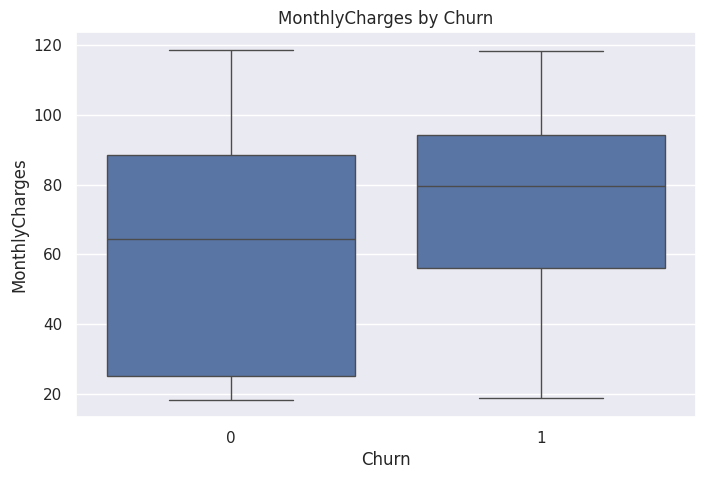

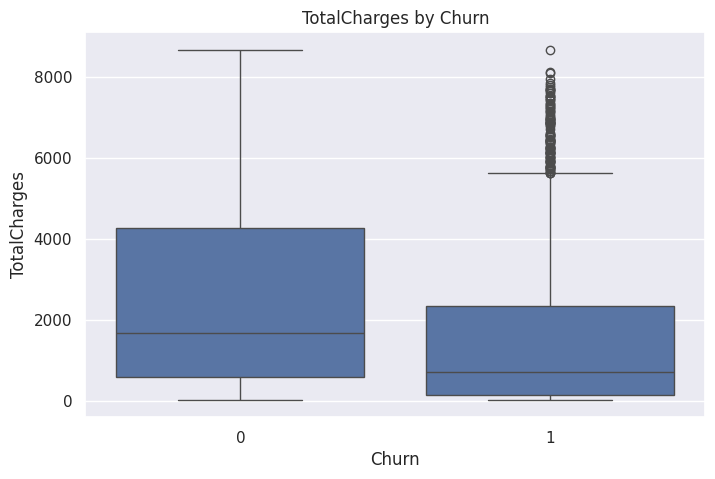

In [11]:
# 7 - EDA plots
import matplotlib.pyplot as plt
import seaborn as sns

# Churn counts
plt.figure()
sns.countplot(data=df, x='Churn')
plt.title('Churn counts (0=No, 1=Yes)')
plt.show()

# Tenure, MonthlyCharges, TotalCharges if present
for col in ['tenure','MonthlyCharges','TotalCharges']:
    if col in df.columns:
        plt.figure()
        sns.boxplot(data=df, x='Churn', y=col)
        plt.title(f'{col} by Churn')
        plt.show()

##EDA: churn distribution and numeric feature comparisons (boxplots)

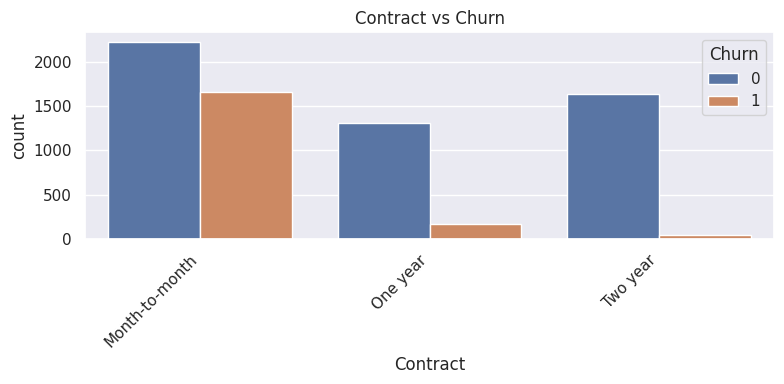

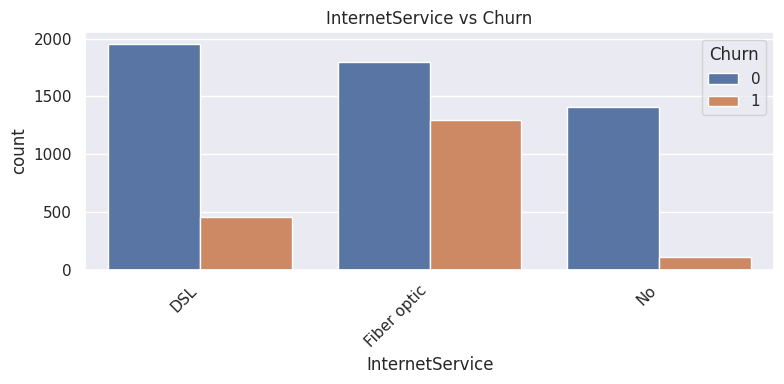

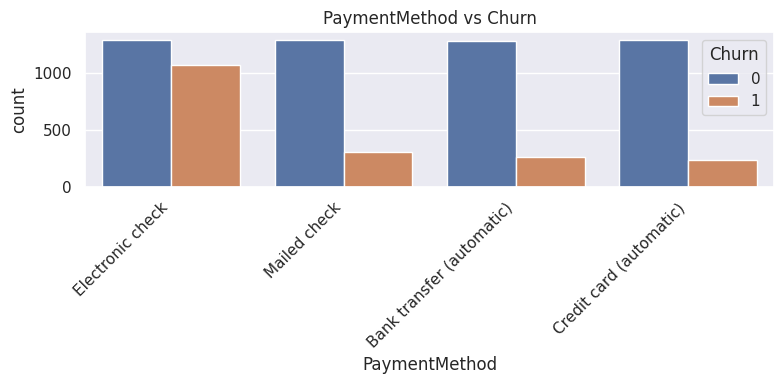

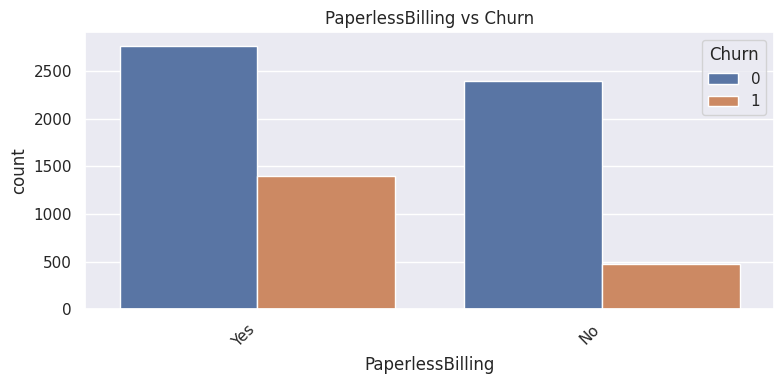

In [12]:
# 8 - categorical vs churn
plot_cols = ['Contract','InternetService','PaymentMethod','PaperlessBilling']
for c in plot_cols:
    if c in df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(data=df, x=c, hue='Churn')
        plt.title(f'{c} vs Churn')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

##Train/test split
Create stratified train/test split (80/20) so class proportions are preserved in both sets.

In [13]:
# 9 - train/test split
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())

Train shape: (5625, 19)
Test shape: (1407, 19)
Train churn rate: 0.2657777777777778 Test churn rate: 0.2658137882018479


## Preprocessing pipeline
Build ColumnTransformer: median imputation + scaling for numeric, most_frequent + one-hot for categorical.

In [14]:
# 10 - preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# if SeniorCitizen shows up as object, convert it
if 'SeniorCitizen' in X_train.columns and X_train['SeniorCitizen'].dtype == 'object':
    X_train['SeniorCitizen'] = X_train['SeniorCitizen'].astype(int)
    X_test['SeniorCitizen'] = X_test['SeniorCitizen'].astype(int)
    if 'SeniorCitizen' in categorical_cols:
        categorical_cols.remove('SeniorCitizen')
        numeric_cols.append('SeniorCitizen')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, [c for c in numeric_cols if c in X_train.columns]),
    ('cat', categorical_transformer, [c for c in categorical_cols if c in X_train.columns])
], remainder='drop')

# Fit preprocessor on training data to inspect how many output features we get
preprocessor.fit(X_train)
try:
    n_cat_feats = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out().shape[0]
except Exception:
    n_cat_feats = 0
n_num = len([c for c in numeric_cols if c in X_train.columns])
print("Numeric features:", n_num, "One-hot features:", n_cat_feats, "Total:", n_num + n_cat_feats)

Numeric features: 4 One-hot features: 41 Total: 45


# Task 2 — Model building & experiments: Decision Tree baseline


####Train a Decision Tree classifier using the preprocessing pipeline and report baseline metrics (accuracy, precision, recall, F1, AUC).

In [15]:
# Decision Tree baseline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score
)

print("Training Decision Tree on SMOTE-resampled data...")

# Train directly on resampled, preprocessed arrays
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_res, y_train_res)

# Predict on test set (use preprocessed X_test_proc)
y_pred_dt = dt_clf.predict(X_test_proc)
y_proba_dt = dt_clf.predict_proba(X_test_proc)[:,1]

# Compute metrics
dt_acc  = accuracy_score(y_test, y_pred_dt)
dt_prec = precision_score(y_test, y_pred_dt, zero_division=0)
dt_rec  = recall_score(y_test, y_pred_dt, zero_division=0)
dt_f1   = f1_score(y_test, y_pred_dt, zero_division=0)
dt_auc  = roc_auc_score(y_test, y_proba_dt)

print("\nDecision Tree - Baseline (SMOTE)")
print(f"Accuracy:  {dt_acc:.4f}")
print(f"Precision: {dt_prec:.4f}")
print(f"Recall:    {dt_rec:.4f}")
print(f"F1 Score:  {dt_f1:.4f}")
print(f"AUC:       {dt_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))

Decision Tree - Baseline
Accuracy: 0.7306, Precision: 0.4934, Recall: 0.4973, F1: 0.4953
AUC: 0.6565

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1033
           1       0.49      0.50      0.50       374

    accuracy                           0.73      1407
   macro avg       0.66      0.66      0.66      1407
weighted avg       0.73      0.73      0.73      1407



### Decision Tree: hyperparameter tuning
a small GridSearchCV to improve Decision Tree performance. Keep the grid modest to save time.

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 6}
Tuned Decision Tree metrics:
F1: 0.5572 Precision: 0.5755 Recall: 0.5401
AUC: 0.796


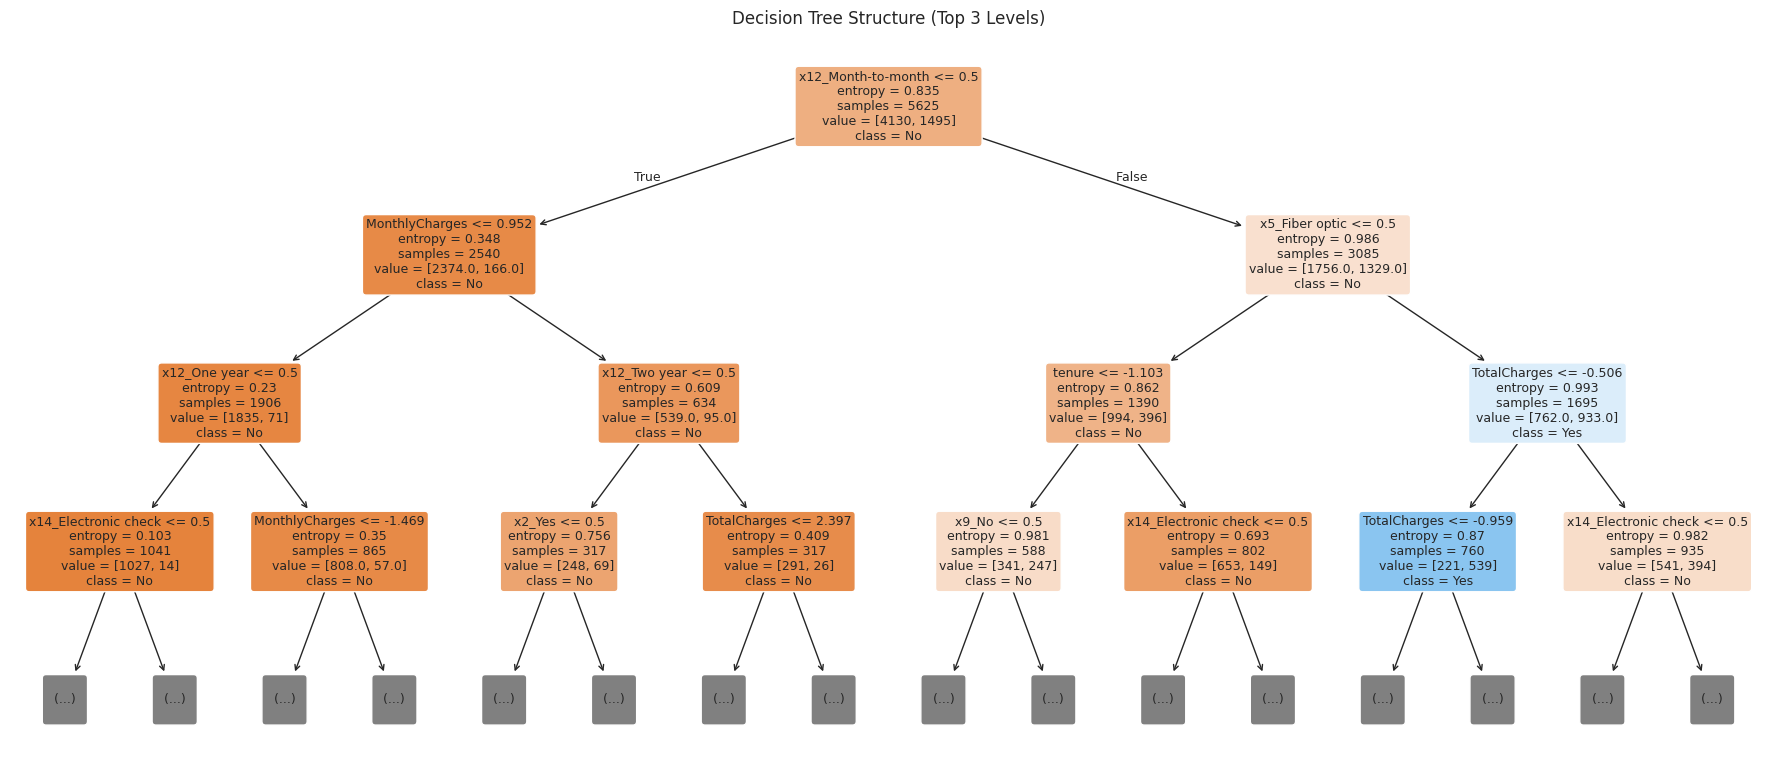

In [23]:
# GridSearchCV for Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 8, 12, None],
    'min_samples_leaf': [1, 3, 6]
}

# Used a plain classifier here because we already preprocessed and SMOTE'd the data
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=4,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit on SMOTE-resampled numeric arrays
grid_dt.fit(X_train_res, y_train_res)

print("Best params:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_

# Evaluate tuned model on the test set
y_pred_best_dt = best_dt.predict(X_test_proc)
y_proba_best_dt = best_dt.predict_proba(X_test_proc)[:,1] if hasattr(best_dt, "predict_proba") else None

print("Tuned Decision Tree metrics:")
print("F1:", round(f1_score(y_test, y_pred_best_dt),4),
      "Precision:", round(precision_score(y_test, y_pred_best_dt, zero_division=0),4),
      "Recall:", round(recall_score(y_test, y_pred_best_dt, zero_division=0),4))
if y_proba_best_dt is not None:
    print("AUC:", round(roc_auc_score(y_test, y_proba_best_dt),4))

from sklearn import tree
from sklearn.tree import export_text

from sklearn import tree

# If best_dt is a pipeline (older code), extract classifier; otherwise use directly
if hasattr(best_dt, "named_steps"):
    clf = best_dt.named_steps.get('clf', None)
else:
    clf = best_dt

# Build feature name list from preprocessor (numeric + one-hot)
num_features = [c for c in numeric_cols if c in X_train.columns]

cat_feature_names = []
try:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = list(ohe.get_feature_names_out())
except Exception:
    cat_feature_names = []

feature_names = num_features + cat_feature_names

# Fallback if mismatch occurs
if clf is None or len(feature_names) != clf.n_features_in_:
    feature_names = [f"f_{i}" for i in range(clf.n_features_in_)]

plt.figure(figsize=(18,8))
tree.plot_tree(
    clf,
    feature_names=feature_names,
    class_names=['No','Yes'],
    max_depth=3,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Decision Tree Structure (Top 3 Levels)")
plt.tight_layout()
plt.show()

### Prepare data arrays for Neural Network
Transform data using the fitted preprocessor so we have numeric arrays for Keras.

In [17]:
# Preprocess and get numpy arrays for NN
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)


# BALANCE TRAINING DATA USING SMOTE

from imblearn.over_sampling import SMOTE

# Use SMOTE on the preprocessed training arrays only (no test leakage)
sm = SMOTE(random_state=42)

# If y_train is a pandas Series, convert to numpy
y_train_arr = y_train.values if hasattr(y_train, "values") else y_train

# Apply SMOTE to the numeric arrays produced by the preprocessor
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train_arr)

print("After SMOTE -> X_train:", X_train_res.shape, "y_train distribution:", np.bincount(y_train_res.astype(int)))
# Now X_train_res and y_train_res are the balanced training set to use for fitting models


print("Preprocessed shapes -> X_train:", X_train_proc.shape, "X_test:", X_test_proc.shape)

Preprocessed shapes -> X_train: (5625, 45) X_test: (1407, 45)


### Neural Network architecture
Define a simple Multi-Layer Perceptron (MLP) with dropout.

In [18]:
# Build a simple Neural Network (Keras)
from tensorflow.keras import layers, models, optimizers

def build_mlp(input_dim, hidden_units=[64,32], lr=1e-3):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    return model

nn_model = build_mlp(X_train_proc.shape[1], hidden_units=[64,32], lr=1e-3)
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train Neural Network with early stopping
Train the NN with a validation split and early stopping to avoid overfitting. Adjust epochs/batch_size as needed.



Epoch 1/50
75/75 - 2s - 25ms/step - AUC: 0.6524 - loss: 0.5722 - val_AUC: 0.8163 - val_loss: 0.4436
Epoch 2/50
75/75 - 0s - 3ms/step - AUC: 0.8172 - loss: 0.4478 - val_AUC: 0.8425 - val_loss: 0.4165
Epoch 3/50
75/75 - 0s - 3ms/step - AUC: 0.8252 - loss: 0.4405 - val_AUC: 0.8463 - val_loss: 0.4087
Epoch 4/50
75/75 - 0s - 3ms/step - AUC: 0.8324 - loss: 0.4328 - val_AUC: 0.8447 - val_loss: 0.4088
Epoch 5/50
75/75 - 0s - 3ms/step - AUC: 0.8359 - loss: 0.4297 - val_AUC: 0.8483 - val_loss: 0.4062
Epoch 6/50
75/75 - 0s - 2ms/step - AUC: 0.8371 - loss: 0.4279 - val_AUC: 0.8496 - val_loss: 0.4068
Epoch 7/50
75/75 - 0s - 3ms/step - AUC: 0.8403 - loss: 0.4253 - val_AUC: 0.8483 - val_loss: 0.4080
Epoch 8/50
75/75 - 0s - 3ms/step - AUC: 0.8442 - loss: 0.4210 - val_AUC: 0.8489 - val_loss: 0.4088
Epoch 9/50
75/75 - 0s - 2ms/step - AUC: 0.8453 - loss: 0.4188 - val_AUC: 0.8497 - val_loss: 0.4072
Epoch 10/50
75/75 - 0s - 2ms/step - AUC: 0.8485 - loss: 0.4153 - val_AUC: 0.8487 - val_loss: 0.4056
Epoch 11

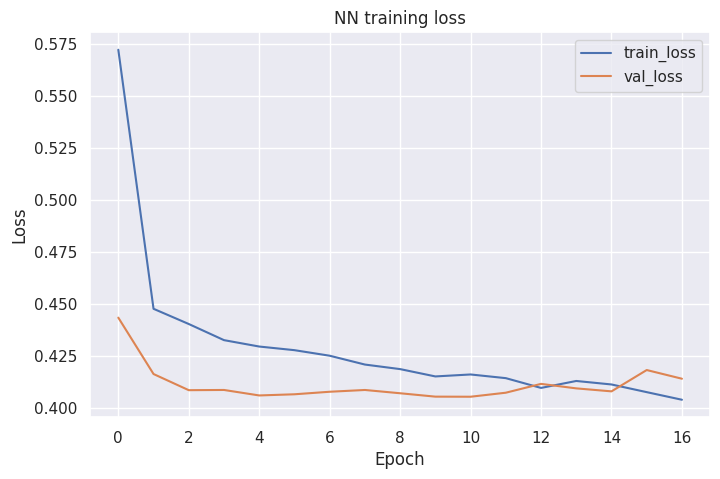

In [19]:
# Train NN with EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = nn_model.fit(
    X_train_proc, y_train.values,
    validation_split=0.15,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# Plot training curves (loss)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('NN training loss'); plt.legend()
plt.show()

### Evaluate Neural Network and Decision Tree (tuned)
Compute metrics for the final models and prepare a comparison table. Plot ROC curves for both.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Accuracy,Precision,Recall,F1,AUC
DecisionTree,0.7719,0.5755,0.5401,0.5572,0.7960
NeuralNet,0.7967,0.6438,0.5267,0.5794,0.8278


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


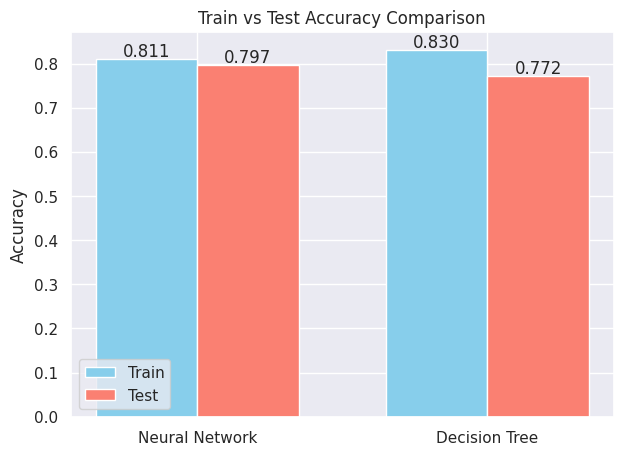

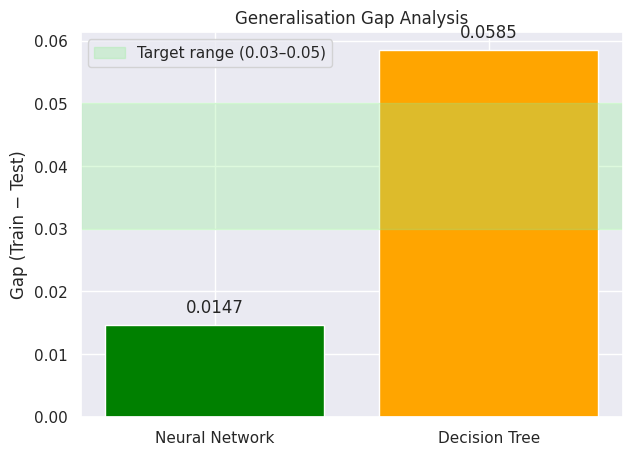

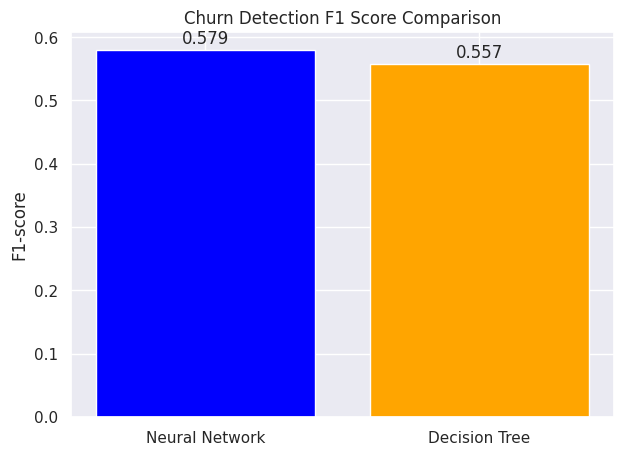

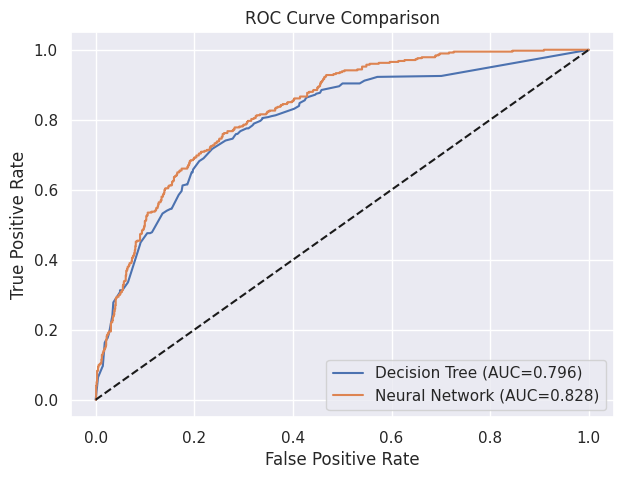

<Figure size 600x400 with 0 Axes>

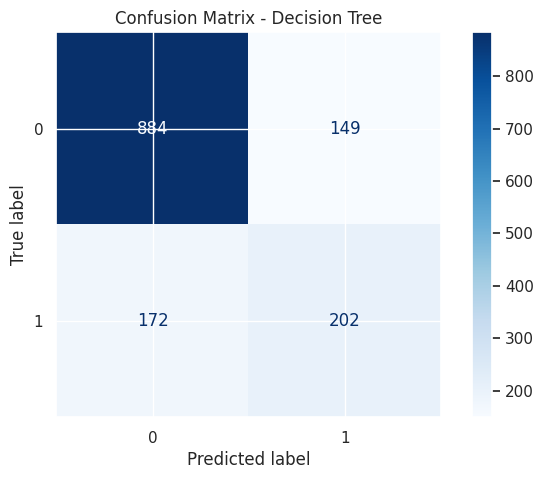

<Figure size 600x400 with 0 Axes>

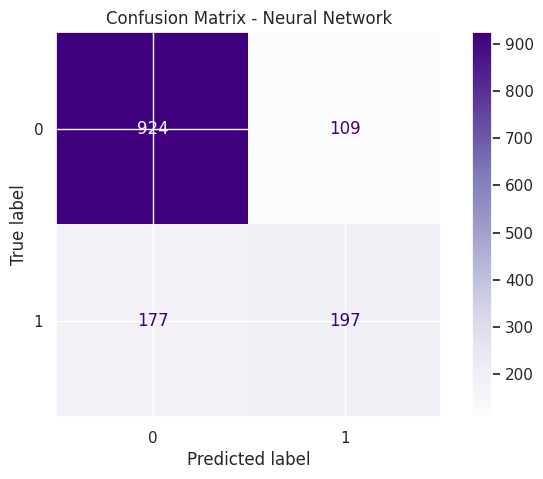

In [20]:
# Evaluate NN and tuned Decision Tree
from sklearn.metrics import roc_curve, auc, confusion_matrix

# NN predictions
nn_probs = nn_model.predict(X_test_proc).ravel()
nn_preds = (nn_probs >= 0.5).astype(int)

# Tuned DT predictions (best_dt from GridSearch)
dt_preds = best_dt.predict(X_test)
dt_probs = best_dt.predict_proba(X_test)[:,1] if hasattr(best_dt.named_steps['clf'], "predict_proba") else None

# Metrics function
def binary_metrics(y_true, y_pred, y_proba=None):
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred),4),
        'Precision': round(precision_score(y_true, y_pred, zero_division=0),4),
        'Recall': round(recall_score(y_true, y_pred, zero_division=0),4),
        'F1': round(f1_score(y_true, y_pred, zero_division=0),4),
        'AUC': round(roc_auc_score(y_true, y_proba),4) if y_proba is not None else None
    }

metrics_dt = binary_metrics(y_test, dt_preds, dt_probs)
metrics_nn = binary_metrics(y_test, nn_preds, nn_probs)

import pandas as pd
res_df = pd.DataFrame([metrics_dt, metrics_nn], index=['DecisionTree','NeuralNet'])
display(res_df)

#  1. Train vs Test Accuracy
plt.figure(figsize=(7,5))
models = ['Neural Network', 'Decision Tree']

train_accs = [
    accuracy_score(y_train, nn_model.predict(X_train_proc).round()),
    accuracy_score(y_train, best_dt.predict(X_train))
]

test_accs = [metrics_nn['Accuracy'], metrics_dt['Accuracy']]

x = np.arange(len(models))
w = 0.35

plt.bar(x - w/2, train_accs, w, label='Train', color='skyblue')
plt.bar(x + w/2, test_accs, w, label='Test', color='salmon')
plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()

for i, v in enumerate(train_accs):
    plt.text(i - w/2, v + 0.005, f"{v:.3f}", ha='center')
for i, v in enumerate(test_accs):
    plt.text(i + w/2, v + 0.005, f"{v:.3f}", ha='center')

plt.show()


#  2. Generalisation Gap
plt.figure(figsize=(7,5))
gen_gap = [abs(train_accs[0] - test_accs[0]),
           abs(train_accs[1] - test_accs[1])]

plt.bar(models, gen_gap, color=['green', 'orange'])
plt.axhspan(0.03, 0.05, color='lightgreen', alpha=0.3, label="Target range (0.03–0.05)")
plt.ylabel("Gap (Train − Test)")
plt.title("Generalisation Gap Analysis")

for i, v in enumerate(gen_gap):
    plt.text(i, v + 0.002, f"{v:.4f}", ha='center')

plt.legend()
plt.show()


#  3. F1-score for churn detection
plt.figure(figsize=(7,5))
plt.bar(models, [metrics_nn['F1'], metrics_dt['F1']], color=['blue','orange'])
plt.ylabel("F1-score")
plt.title("Churn Detection F1 Score Comparison")

for i, v in enumerate([metrics_nn['F1'], metrics_dt['F1']]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')

plt.show()


# 4. ROC Curve
plt.figure(figsize=(7,5))

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc(fpr_dt,tpr_dt):.3f})")

fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC={auc(fpr_nn,tpr_nn):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.show()

# Confusion Matrix for both models
from sklearn.metrics import ConfusionMatrixDisplay

# Decision Tree confusion matrix
plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_test, dt_preds, cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Neural Network confusion matrix
plt.figure(figsize=(6,4))
ConfusionMatrixDisplay.from_predictions(y_test, nn_preds, cmap="Purples")
plt.title("Confusion Matrix - Neural Network")
plt.show()



### Save final models
Save the tuned Decision Tree pipeline and Keras model for submission or future use.

In [21]:
# Save models to disk
import joblib, os
os.makedirs('/content/models', exist_ok=True)

# Save sklearn pipeline (best_dt contains preprocessor + clf)
joblib.dump(best_dt, '/content/models/best_dt_pipeline.joblib')
# Save Keras model
nn_model.save('/content/models/nn_model.h5')

print("Saved models to /content/models")

Saved models to /content/models
